# Transformada de Fourier

## Filtros no domínio da Frequência

#### Fourier Transform in Numpy

Vamos aprender como encontrar a Transformada de Fourier utilizando o Numpy. Numpy tem um pacote FFT para fazer isso. **np.fft.fft2()** provê a transformação para o domínio da frequência, que será uma matriz (array) complexa. O primeiro argumento é a imagem de entrada, que é **nível de cinza**. O segundo argumento é opcional que decide o tamanho da matriz de saída. Se nenhum argumento é passado, o tamanho da matriz de saída será o mesmo da entrada.

Uma vez que temos o resultado, a componente de frequência zero (componente DC) estará no topo esquerdo. Se queremos trazê-la para o centro, precisamos deslocar o resultado por $\frac{N}{2}$ em ambas as direções. Isto é feito automagicamente pela função **np.fft.fftshift()**

In [1]:
%matplotlib inline

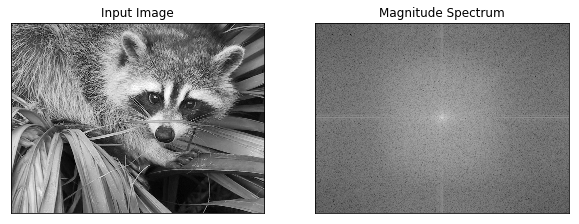

In [3]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
from pylab import rcParams
from scipy import misc

rcParams['figure.figsize'] = 10, 10

img_c = misc.face()
img = rgb2gray(img_c)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift))

plt.subplot(121),
plt.imshow(img, cmap = 'gray')
plt.title('Input Image')
plt.xticks([]) 
plt.yticks([])

plt.subplot(122)
plt.imshow(np.log(np.abs(fshift)), cmap='gray')
plt.title('Magnitude Spectrum')
plt.xticks([])
plt.yticks([])
plt.show()

Assim, obtemos uma imagem da magnitude do espectro mostrando a região mais clara no centro, onde estão as baixas frequências.

Agora podemos fazer alguns filtros no domínio da frequência utilizando esta técnica.

No trecho abaixo, vamos remover as baixas frequências fazendo uma máscara retangular (quadrada) de 60x60. É uma aplicação bem direta (simplesmente *zeramos* os valores que estão dentro desta máscara. 
 
    fshift[crow-30:crow+30, ccol-30:ccol+30] = 0

Depois fazemos o deslocamento inverto, isto é, retornamos a componente de frequência zero para o topo esquerdo superior e então calculamos a transformada inversa.

Tomamos os valores absolutos da imagem (é um imagem com valores complexos), que nos dá uma imagem resultante de um filtro passa alta.

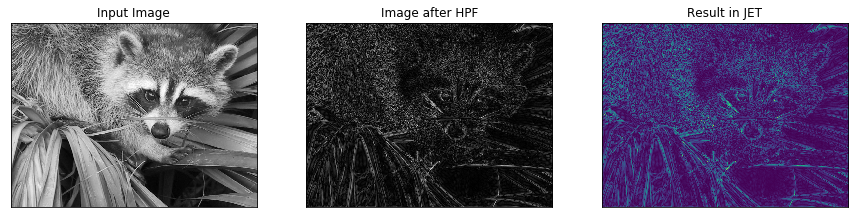

In [4]:
rows, cols = img.shape
crow, ccol = int(rows/2) , int(cols/2)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

rcParams['figure.figsize'] = 15, 10

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()

O resultado mostra que um filtro passa alta é uma operação de detecção de bordas. Nós vimos isso com os filtros de gradientes (no domínio espacial). Isto também mostra que a maioria dos dados (informação) de uma imagem está presente na região de baixa frequência do espectro. De qualquer modo, vimos como fazer uma DFT, IDFT, etc, no Numpy. 

```
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc

def butter2d_lp(shape, f, n, pxd=1): 
    """Designs an n-th order lowpass 2D Butterworth filter with cutoff
    frequency f. pxd defines the number of pixels per unit of frequency (e.g.,
    degrees of visual angle)."""
    pxd = float(pxd)
    rows, cols = shape 
    x = np.linspace(-0.5, 0.5, cols)  * cols / pxd
    y = np.linspace(-0.5, 0.5, rows)  * rows / pxd
    radius = np.sqrt((x**2)[np.newaxis] + (y**2)[:, np.newaxis]) 
    filt = 1 / (1.0 + (radius / f)**(2*n))
    return filt

def butter2d_bp(shape, cutin, cutoff, n, pxd=1):
    """Designs an n-th order bandpass 2D Butterworth filter with cutin and
    cutoff frequencies. pxd defines the number of pixels per unit of frequency
    (e.g., degrees of visual angle)."""
    return butter2d_lp(shape,cutoff,n,pxd) - butter2d_lp(shape,cutin,n,pxd)

def butter2d_hp(shape, f, n, pxd=1):
    """Designs an n-th order highpass 2D Butterworth filter with cutin
    frequency f. pxd defines the number of pixels per unit of frequency (e.g.,
    degrees of visual angle)."""
    return 1. - butter2d_lp(shape, f, n, pxd)

def ideal2d_lp(shape, f, pxd=1):
    """Designs an ideal filter with cutoff frequency f. pxd defines the number
    of pixels per unit of frequency (e.g., degrees of visual angle)."""
    pxd = float(pxd)
    rows, cols = shape 
    x = np.linspace(-0.5, 0.5, cols)  * cols / pxd
    y = np.linspace(-0.5, 0.5, rows)  * rows / pxd
    radius = np.sqrt((x**2)[np.newaxis] + (y**2)[:, np.newaxis]) 
    filt = np.ones(shape)
    filt[radius>f] = 0
    return filt

def ideal2d_bp(shape, cutin, cutoff, pxd=1):
    """Designs an ideal filter with cutin and cutoff frequencies. pxd defines
    the number of pixels per unit of frequency (e.g., degrees of visual
    angle)."""
    return ideal2d_lp(shape,cutoff,pxd) - ideal2d_lp(shape,cutin,pxd)

def ideal2d_hp(shape, f, n, pxd=1):
    """Designs an ideal filter with cutin frequency f. pxd defines the number
    of pixels per unit of frequency (e.g., degrees of visual angle)."""
    return 1. - ideal2d_lp(shape, f, n, pxd)

def bandpass(data, highpass, lowpass, n, pxd, eq='histogram'):
    """Designs then applies a 2D bandpass filter to the data array. If n is
    None, and ideal filter (with perfectly sharp transitions) is used
    instead."""
    fft = np.fft.fftshift(np.fft.fft2(data))
    if n:
        H = butter2d_bp(data.shape, highpass, lowpass, n, pxd)
    else:
        H = ideal2d_bp(data.shape, highpass, lowpass, pxd)
    fft_new = fft * H
    new_image = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_new)))    
    if eq == 'histogram':
        new_image = exposure.equalize_hist(new_image)
    return new_image
```



## Exercícios

### Exercício 1

Crie uma imagem de 30x30, preenchida com zeros e depois crie um retângulo de 5:24 em **x** e de 13:17 em **y**, com valor 1.

Depois calcule a Transformada Rápida de Fourier (`fft2`), e obtenha uma imagem (magnitude do espectro), conforme mostrado.

Crie uma nova imagem adicionando zeros à imagem do retângulo (isto é chamado de *padding*) de modo que ela fique com tamanho 256x256 e então calcule novamente a Transformada de Fourier e comente as diferenças dos espectros.

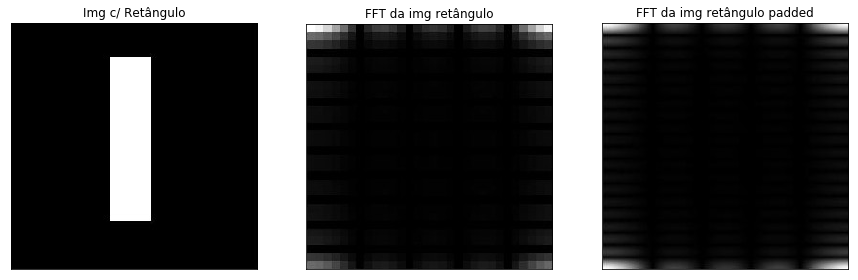

In [6]:
imgrectangle = io.imread('images-for-notebooks/rectangle.jpg')
imgrectspect1 = io.imread('images-for-notebooks/rectangle_spectrum1.jpg')
imgrectspect2 = io.imread('images-for-notebooks/rectangle_spectrum2.jpg')
rcParams['figure.figsize'] = 15, 10

plt.subplot(131)
plt.imshow(imgrectangle, cmap = 'gray')
plt.title('Img c/ Retângulo')
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.imshow(imgrectspect1, cmap = 'gray')
plt.title('FFT da img retângulo')
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.imshow(imgrectspect2)
plt.title('FFT da img retângulo padded')
plt.xticks([])
plt.yticks([])

plt.show()

Agora faça um *shift* da Transformada, reposicionando-a, de modo que a origem fique no centro da imagem.

Por último neste exercício, aplique uma transformação logarítmica à Transformada para mostrar mais detalhes do espectro.

### Exercício 2

Aplique um Filtro Gaussiano passa-baixa na imagem da *bola* de futebol americano mostrada abaixo. Lembre-se de fazer o *padding* da imagem de modo que ela fique com dimensões que sejam potência de 2, e seja uma **imagem quadrada**. Você deve mostrar a imagem original, o espectro de Fourier (magnitude do espectro), a imagem da bola após a aplicação do filtro e o espectro de Fourier filtrado com o Filtro Gaussiano passa-baixa.

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


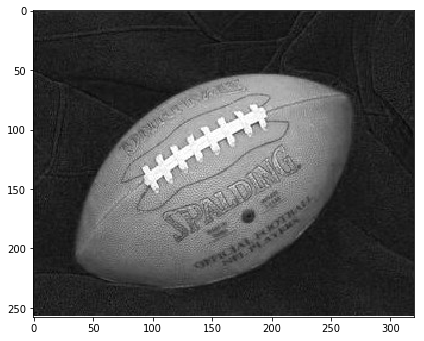

In [8]:
imgbola = io.imread('images-for-notebooks/footBall_orig.jpg')
fig = plt.figure(figsize = (15,7))
ax_each = fig.add_subplot(121, adjustable = 'box-forced')
ax_each.imshow(imgbola)
plt.show()

## Exercício 3

Aplique um Filtro Gaussiano passa-alta na imagem da bola de futebol americano. Lembre-se de fazer o *padding* da imagem original para ficar com dimensões potência de 2 e seja uma imagem quadrada. Você deve mostrar o espectro de Fourier (magnitude do espectro), a imagem da bola após a aplicação do Filtro e o espectro de Fourier filtrado.

### Exercício 4

Filtros de *entalhe* (recorte, pontuais):

* são utilizados para remover ruído *espectral* repetitivo de uma imagem;
* são como um pequeno filtro passa alta, mas eles *recortam* (removem) frequências específicas, ao invés da  [componente *dc*](https://forum.allaboutcircuits.com/threads/what-is-the-dc-component.7210/), [*dc* component](https://www.tutorialspoint.com/signals_and_systems/dc_component.asp)
* atenua uma frequência selecionada (e algumas de suas vizinhas) e deixa as outras frequências da transformada de Fourier relativamente não modificadas.
* podemos construir tipos diferentes de filtros de *entalhe* a partir dos filtros exemplificados anteriormente:
    * "ideal" - um filtro ideal passa alta com uma frequência de corte D0 (D0 > 0)
    * "butterworth" - um filtro butterworth passa alta de ordem *n*, e corte D0. Valor default de *n* é 1.0 (D0 > 0)
    * "gaussiano" - um filtro gaussiano passa alta com um frequência de corte (desvio padrão) D0 (D0 > 0)

Estes filtros podem ser implementados com uma função do tipo:

`entalhe(tipo, M, N, D0, x, y, n)`  
  - função para aplicar o filtro de *entalhe* do `tipo` especificado, dentrado na coluna `x`, linha `y`, em um espectro de Fourier não deslocado. `D0` é a frequẽncia de corte e `n` é a ordem do filtro Butterworth; não usado para os demais tipos.


Ruído repetitivo em uma imagem é algumas vezes visto como um ponto brilhante, diferente da origem. É possível suprimir tal ruído efetivamente através da remoção cuidadosa destes picos. Uma maneira de se fazer isso é utilizar um filtro de *entalhe* que simplesmente remove aquela frequência da imagem. Esta técnica é muita comum no processamento de sinais de áudio, onde ela é utilizada para remover zumbidos mecânicos ou eletrônicos, tais como o zumbido de 60Hz de fontes de corrente alternada (AC). Normalmente, estes filtros são criados através de procedimentos *ad hoc*, requerendo um expert humano para determinar quais frequências que devem ser removidas para limpar o sinal.

As imagens a seguir demonstram este procedimento de se remover um ruído espectral de uma imagem.

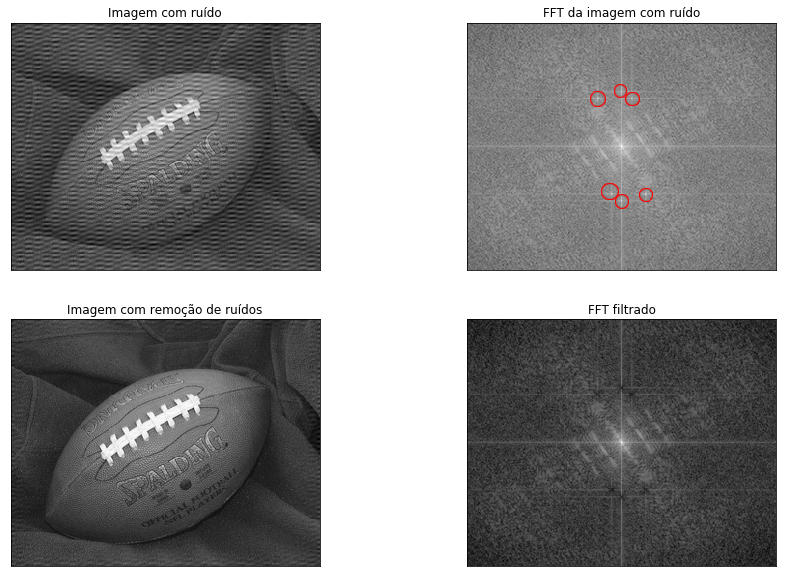

In [11]:
imgnoiseball = io.imread('images-for-notebooks/noiseball.png')
imgnoise_spectrum = io.imread('images-for-notebooks/noise_spectrum.png')
imgfixed_ball = io.imread('images-for-notebooks/fixed_football.png')
imgfixed_spectrum = io.imread('images-for-notebooks/fixed_spectrum.png')
rcParams['figure.figsize'] = 15, 10

plt.subplot(221)
plt.imshow(imgnoiseball, cmap = 'gray')
plt.title('Imagem com ruído')
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.imshow(imgnoise_spectrum, cmap = 'gray')
plt.title('FFT da imagem com ruído')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(imgfixed_ball, cmap = 'gray')
plt.title('Imagem com remoção de ruídos')
plt.xticks([])
plt.yticks([])

plt.subplot(224)
plt.imshow(imgfixed_spectrum, cmap = 'gray')
plt.title('FFT filtrado')
plt.xticks([])
plt.yticks([])

plt.show()

### Exercício 5 - Melhoria de Imagem *a la* CSI

Você agora é um especialista em processamento de imagens para um departamento de investigação. Um detective abriu um caso antigo e parte de sua evidência é a foto de carro em um jornal (de papel). Você então é requisitado para fazer alguma mágica, tipo CSI, para tentar reconhecer a placa do carro ou tentar identificar o suspeito.

1. Pegue a imagem **car_noise_pattern_halftone.png** e utilize as técnicas anteriores (filtros de *entalhe*, suavização, etc) para restaurar a imagem.  
**Dicas**:

- crie uma função que receba uma lista de picos (onde estão os picos de ruídos) como um argumento;
- os picos formam um padrão repetitivo. Descubra este padrão para economizar tempo.

2. Faça um ajuste fino nos seus filtros, mudando as larguras dos três tipos de filtros (`D0`) e experimentando, se necessário, alguma suavização no domínio da frequência. Você deve entregar a melhor solução para cada tipo de filtro. 

3. Use um programa de processamento de imagens (Photoshop/Gimp) e faça uma suavização na imagem original. Você deve entregar esta imagem suavizada.

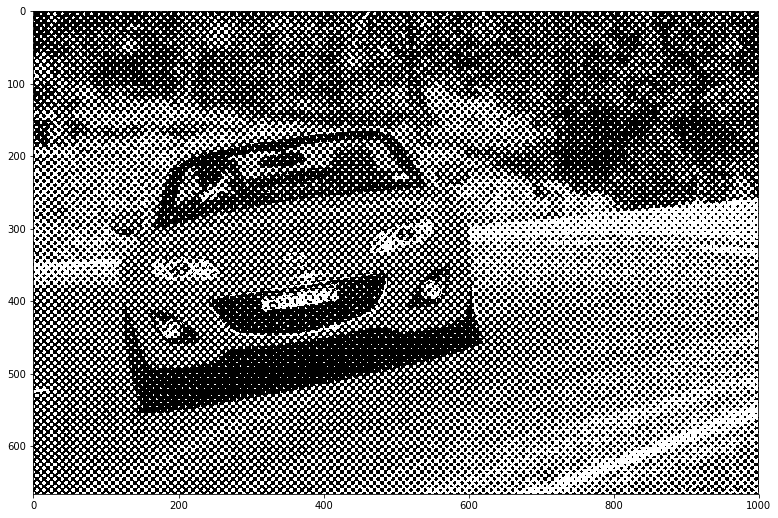

In [10]:
imgcarro = io.imread('images-for-notebooks/car_noise_pattern_halftone.png')
rcParams['figure.figsize'] = 13, 9
plt.subplot(111)
plt.imshow(imgcarro, cmap = 'gray')
plt.show()